In [23]:
!pip install torch-geometric

In [24]:
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
from torch_geometric.data import Data
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch
import torch.optim as optim

In [25]:
def load_and_preprocess_data(data_path, target_column, n_lags):
    dataset = pd.read_excel(data_path, skiprows=2)
    dataset = dataset.drop(['M/d/yyyy'], axis=1)

    for lag in range(1, n_lags + 1):
        dataset[f'{target_column}_lag_{lag}'] = dataset[target_column].shift(lag)
    dataset.dropna(inplace=True)

    X = dataset.drop([target_column], axis=1)
    y = dataset[target_column]

    return X, y

def prepare_data(X, y, test_size=0.2, random_state=42):

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, random_state=random_state)

    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float)
    y_train_tensor = torch.tensor(y_train.values, dtype=torch.float).view(-1, 1)
    X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float)
    y_test_tensor = torch.tensor(y_test.values, dtype=torch.float).view(-1, 1)

    return X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor


Epoch	Loss
50	0.0006841735448688269
100	6.764252611901611e-05
Mean Absolute Error (MAE): 0.00537895
Root Mean Squared Error (RMSE): 0.0072605447


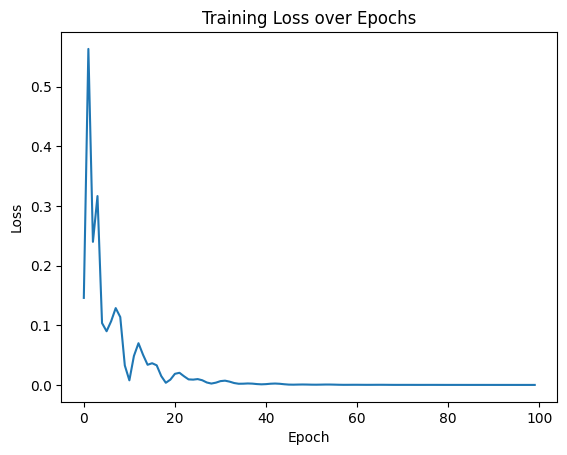

In [26]:
class MLP(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(MLP, self).__init__()
        self.fc1 = nn.Linear(input_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = self.fc2(x)
        return x

def train_mlp_model(X_train_tensor, y_train_tensor, input_size, hidden_size, output_size, num_epochs=100, learning_rate=0.05):
    model_mlp = MLP(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_mlp.parameters(), lr=learning_rate)

    losses_mlp = []

    print('Epoch\tLoss')
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model_mlp(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses_mlp.append(loss.item())

        if (epoch + 1) % 50 == 0:
            print(f'{epoch+1}\t{loss.item()}')

    return model_mlp, losses_mlp

if __name__ == "__main__":
    data_path = 'WW01_v3.xls'
    target_column = 'ft'
    n_lags = 3

    X, y = load_and_preprocess_data(data_path, target_column, n_lags)
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = prepare_data(X, y)

    input_size = X_train_tensor.shape[1]
    hidden_size = 16
    output_size = 1
    num_epochs = 100
    learning_rate = 0.05

    model_mlp, losses = train_mlp_model(X_train_tensor, y_train_tensor, input_size, hidden_size, output_size, num_epochs, learning_rate)

    with torch.no_grad():
        y_pred_tensor = model_mlp(X_test_tensor)

    y_test = y_test_tensor.numpy()
    y_pred = y_pred_tensor.numpy()

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))

    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

Epoch	Loss
10	0.6461082100868225
20	0.3939332067966461
30	0.1489657312631607
40	0.03033623844385147
50	0.005727644544094801
60	0.0022325257305055857
70	0.0016246509039774537
80	0.0002616233250591904
90	0.00037070896360091865
100	0.00012789784523192793
Mean Absolute Error (MAE): 0.036566403
Root Mean Squared Error (RMSE): 0.10239


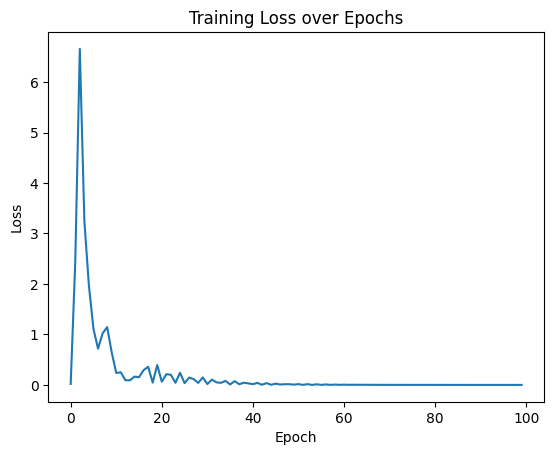

In [27]:
class RNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=2):
        super(RNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.rnn = nn.RNN(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.rnn(x)
        out = self.fc(out)
        return out

def train_rnn_model(X_train_tensor, y_train_tensor, input_size, hidden_size, output_size, num_epochs=100, learning_rate=0.1):
    model_rnn = RNN(input_size, hidden_size, output_size)
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model_rnn.parameters(), lr=learning_rate)

    losses = []

    print('Epoch\tLoss')
    for epoch in range(num_epochs):
        optimizer.zero_grad()
        outputs = model_rnn(X_train_tensor)
        loss = criterion(outputs, y_train_tensor)
        loss.backward()
        optimizer.step()
        losses.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f'{epoch+1}\t{loss.item()}')

    return model_rnn, losses

if __name__ == "__main__":
    data_path = 'WW01_v3.xls'
    target_column = 'ft'
    n_lags = 3

    X, y = load_and_preprocess_data(data_path, target_column, n_lags)
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = prepare_data(X, y)

    input_size = X_train_tensor.shape[1]
    hidden_size = 64
    output_size = 1
    num_epochs = 100
    learning_rate = 0.1

    model_rnn, losses = train_rnn_model(X_train_tensor, y_train_tensor, input_size, hidden_size, output_size, num_epochs, learning_rate)


    with torch.no_grad():
        y_pred_tensor = model_rnn(X_test_tensor)


    y_test = y_test_tensor.numpy()
    y_pred = y_pred_tensor.numpy()

    mae = mean_absolute_error(y_test, y_pred)
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))


    print("Mean Absolute Error (MAE):", mae)
    print("Root Mean Squared Error (RMSE):", rmse)
    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()

Edge index size: torch.Size([2, 684])
Epoch	Loss
50	0.0024841870181262493
100	0.0012488615466281772
150	0.0008871312020346522
200	0.0006783397984690964
GCN- MAE: 0.028158964589238167, RMSE: 0.034390613436698914


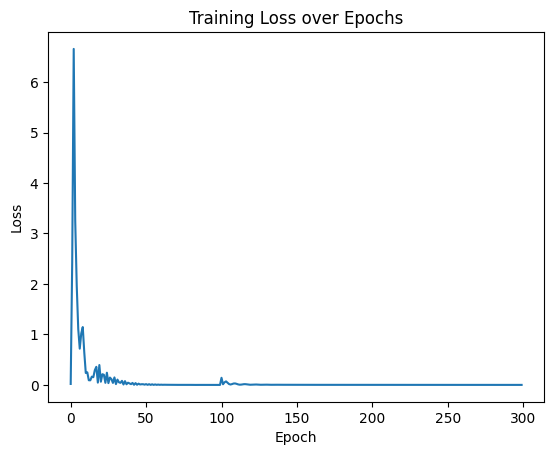

In [28]:
def train_gcn_model(X_train_tensor, edge_index, y_train_tensor, input_size, num_epochs=200, learning_rate=0.01):
    data_gcn = Data(x=X_train_tensor, edge_index=edge_index)

    model_gcn = GCNModel(input_size)
    optimizer_gcn = optim.Adam(model_gcn.parameters(), lr=learning_rate)

    losses_gcn = []

    print('Epoch\tLoss')
    for epoch in range(num_epochs):
        optimizer_gcn.zero_grad()
        output = model_gcn(data_gcn)
        loss = F.mse_loss(output, y_train_tensor)
        loss.backward()
        optimizer_gcn.step()
        losses.append(loss.item())
        if (epoch + 1) % 50 == 0:
            print(f'{epoch+1}\t{loss.item()}')


    return model_gcn, losses

def evaluate(model, X_test_tensor, y_test_tensor, edge_index):
    valid_edges_mask = (edge_index[0] < X_test_tensor.size(0)) & (edge_index[1] < X_test_tensor.size(0))
    edge_index_test = edge_index[:, valid_edges_mask]
    data_gcn_test = Data(x=X_test_tensor, edge_index=edge_index_test)

    with torch.no_grad():
        output = model(data_gcn_test)
    predicted = output.cpu().numpy()

    mae = mean_absolute_error(y_test_tensor, predicted)
    rmse = np.sqrt(mean_squared_error(y_test_tensor, predicted))
    return mae, rmse

class GCNModel(nn.Module):
    def __init__(self, input_size):
        super(GCNModel, self).__init__()
        self.conv1 = GCNConv(input_size, 16)
        self.conv2 = GCNConv(16, 1)

    def forward(self, data):
        x, edge_index = data.x, data.edge_index
        x = F.relu(self.conv1(x, edge_index))
        x = self.conv2(x, edge_index)
        return x

if __name__ == "__main__":
    data_path = 'WW01_v3.xls'
    target_column = 'ft'
    n_lags = 3

    X, y = load_and_preprocess_data(data_path, target_column, n_lags)
    X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor = prepare_data(X, y)

    num_nodes = X_train_tensor.size(0)
    edges = [[i, i + 1] for i in range(X_train_tensor.size(0) - 1)]
    edges += [[i + 1, i] for i in range(X_train_tensor.size(0) - 1)]
    edge_index = torch.tensor(edges, dtype=torch.long).t().contiguous()

    print("Edge index size:", edge_index.size())

    model_gcn, losses = train_gcn_model(X_train_tensor, edge_index, y_train_tensor, X_train_tensor.size(1))
    mae_gcn, rmse_gcn = evaluate(model_gcn, X_test_tensor, y_test_tensor, edge_index)
    print(f'GCN- MAE: {mae_gcn}, RMSE: {rmse_gcn}')

    plt.plot(losses)
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training Loss over Epochs')
    plt.show()